# Building a Controller for a storage unit

The following documents the development of a new controller.
In this case we are going to implement an arbitrary controllable storage unit.
This could be a water tank, an underground cavern storage or some sort of reservoir storage.
The purpose of this storage is to store mass (of a fluid). The temperature or changes in the
composition are neglected.

## Modelling a mass storage

In order to simulate a storage system we use the mass storage element of pandapipes. The mass flow
of a storage can be positive or negative.

For storage elements the signing is based on the consumer viewpoint (positive flow means "charging"
of the storage, negative flow means that the fluid is leaving the storage).

As pandapipes is not a time dependent simulation tool and there is no time domain parameter in
default pipe flow calculations, the amount of stored mass is not updated during any regular pipe
flow calculation. In order to update the "filling level" (State of Charge) (`m_stored_kg`),
we build our own storage controller and keep track of the SoC.

## Controller init
First we start by creating a new file *control/storage_control.py*, containing our new class.

We import and inherit from the parent class `Controller` (from pandapower) and override methods that are only dummy methods in the parent class.

The most important methods are
- `time_step`,
which will be called by `run_time_series` -> `run_loop` -> `run_time_step` -> `control_time_step` -> `Controller.time_step(net, timestep)`
- `write_to_net`,
which will afterwards be called by `run_time_series` -> `run_loop` -> `run_time_step` -> `run_control_fct` -> `control_implementation` -> `_control_step` -> `Controller.control_step(net)`.

Depending on the particular storage design, they may need to be adapted to specify the storage's
charging behavior or to include more, user-defined variables, i.e. filling height.

In [20]:
import pandapipes as pp
from pandapower.control.basic_controller import Controller


class StorageController(Controller):
    """
        Example class of a Storage-Controller. Models an abstract mass storage.
    """
    def __init__(self, net, sid, data_source=None, mdot_profile=None, in_service=True,
                 recycle=False, order=0, level=0, duration_timestep_h=1, **kwargs):
        super().__init__(net, in_service=in_service, recycle=recycle, order=order, level=level,
                    initial_pipeflow = True, **kwargs)
        
        # read storage attributes from net
        self.sid = sid  # index of the controlled storage
        self.junction = net.mass_storage.at[sid, "junction"]
        self.mdot_kg_per_s = net.mass_storage.at[sid, "mdot_kg_per_s"]
        self.name = net.mass_storage.at[sid, "name"]
        self.storage_type = net.mass_storage.at[sid, "type"]
        self.in_service = net.mass_storage.at[sid, "in_service"]
        self.scaling = net.mass_storage.at[sid, "scaling"]
        self.applied = False

        # specific attributes
        self.max_m_kg = net.mass_storage.at[sid, "max_m_stored_kg"]
        self.min_m_kg = net.mass_storage.at[sid, "min_m_stored_kg"]
        self.m_stored_kg = net.mass_storage.at[sid, "init_m_stored_kg"]

        # profile attributes
        self.data_source = data_source
        self.mdot_profile = mdot_profile
        self.last_time_step = 0
        self.duration_ts_sec = duration_timestep_h * 3600

    # In a time-series simulation the mass storage should read new flow values from a profile and keep track
    # of its amount of stored mass as depicted below.
    def time_step(self, net, time):
        # keep track of the stored mass (the duration of one time step is given as input to the controller)
        if self.last_time_step is not None:
            # The amount of mass that flowed into or out of the storage in the last timestep is added
            # requested change of mass:
            self.delta_m_kg_req = (self.mdot_kg_per_s * (time - self.last_time_step)
                                   * self.duration_ts_sec)
            # limit by available mass and free capacity in the storage:
            if self.delta_m_kg_req > 0:  # "charging"
                self.delta_m_kg_real = min(self.delta_m_kg_req, self.max_m_kg - self.m_stored_kg)
            else:  # "discharging", delta < 0
                self.delta_m_kg_real = max(self.delta_m_kg_req, self.min_m_kg - self.m_stored_kg)
            self.m_stored_kg += self.delta_m_kg_real
            self.mdot_kg_per_s = self.delta_m_kg_real / ((time - self.last_time_step)
                                                         * self.duration_ts_sec)
        self.last_time_step = time

        # read new values from a profile
        if self.data_source:
            if self.mdot_profile is not None:
                self.mdot_kg_per_s = self.data_source.get_time_step_value(time_step=time,
                                                                          profile_name=self.mdot_profile)
                self.m_stored_kg *= self.scaling * self.in_service

        self.applied = False  # reset applied variable

    # Some convenience methods to calculate indicators for the state of charge:
    def get_stored_mass(self):
        # return the absolute stored mass
        return self.m_stored_kg

    def get_free_stored_mass(self):
        # return the stored mass excl. minimum filling level
        return self.m_stored_kg - self.min_m_kg

    def get_filling_level_percent(self):
        # return the ratio of absolute stored mass and total maximum storable mass in Percent
        return 100 * self.get_stored_mass() / self.max_m_kg

    def get_free_filling_level_percent(self):
        # return the ratio of available stored mass (i.e. excl. min_m_stored_kg) and difference between max and min in Percent
        return 100 * self.get_free_stored_mass() / (self.max_m_kg - self.min_m_kg)

    # Define which values in the net shall be updated
    def write_to_net(self, net):
        # write mdot_kg_per_s, m_stored_kg to the table in the net
        net.mass_storage.at[self.sid, "mdot_kg_per_s"] = self.mdot_kg_per_s
        net.mass_storage.at[self.sid, "m_stored_kg"] = self.m_stored_kg
        net.mass_storage.at[self.sid, "filling_level_percent"] = \
            self.get_free_filling_level_percent()
        # Note: a pipeflow will automatically be conducted in the run_timeseries / run_control procedure.
        # This will then update the result table (net.res_mass_storage).
        # If something was written to net.res_mass_storage in this method here, the pipeflow would overwrite it.

    # In case the controller is not yet converged (i.e. in the first iteration,
    # maybe also more iterations for more complex controllers), the control step is executed.
    # In the example it simply adopts a new value according to the previously calculated target
    # and writes back to the net.
    def control_step(self, net):
        # Call write_to_net and set the applied variable True
        self.write_to_net(net)
        self.applied = True

    # convergence check
    def is_converged(self, net):
        # check if controller already was applied
        return self.applied


We are now ready to create objects of our newly implemented class and use it in a simulation:

In [21]:
import pandas as pd

import pandapower.timeseries as ts
# importing a grid from the library
from pandapipes.networks import gas_meshed_square

# loading the network
net = gas_meshed_square()
pp.pipeflow(net)

# creating a simple time series
framedata = pd.DataFrame([0.1, .05, -0.1, .005, -0.2, 0], columns=['mdot_storage'])
datasource = ts.DFData(framedata)

# creating storage unit in the grid, which will be controlled by our controller
store_mass = pp.create_mass_storage(net, junction=3,
                                    mdot_kg_per_s=0, init_m_stored_kg=2, min_m_stored_kg=0, max_m_stored_kg=500,
                                    type="classical mass storage")

# creating an Object of our new build storage controller, controlling the storage unit
ctrl = StorageController(net=net, sid=store_mass, data_source=datasource, mdot_profile='mdot_storage')

hp.pandapower.control.util.auxiliary - INFO: Creating controller 0 of type <class '__main__.StorageController'> 


If required, we could also pass other arguments to the `create_mass_storage` function as key word arguments, i.e. the floor area of the storage, and use them in the `StorageController` class.

Now we run a small time-series-simulation and track the results using the outputwriter:

In [22]:
from pandapipes.timeseries import run_timeseries
# defining an OutputWriter to track certain variables
log_variables = [("mass_storage", "mdot_kg_per_s"), ("res_mass_storage", "mdot_kg_per_s"),
                 ("mass_storage", "m_stored_kg")]
ow = ts.OutputWriter(net, log_variables=log_variables)

# starting time series simulation
run_timeseries(net, time_steps=range(0, 6))

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\e2n236\AppData\Local\Temp\ipykernel_14224\856783411.py:50: RuntimeWarning: invalid value encountered in double_scalars
  self.mdot_kg_per_s = self.delta_m_kg_real / ((time - self.last_time_step)
100%|██████████| 6/6 [00:00<00:00, 73.58it/s]


To visualize the results we plot directly with the dataframe:

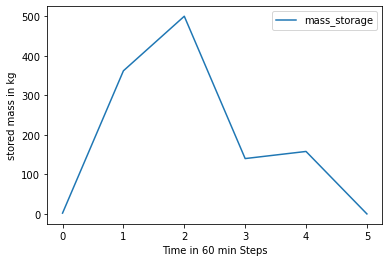

In [23]:
# plotting the state of charge
ow.output['mass_storage.m_stored_kg'].columns = ['mass_storage']
ax = ow.output['mass_storage.m_stored_kg'].plot()
ax.set_xlabel('Time in 60 min Steps')
ax.set_ylabel('stored mass in kg')
ax.legend()